In [ ]:
import os
import re
import os
import tqdm
from glob import glob
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pprint import pprint
import graphviz

from collections import defaultdict
from bs4 import BeautifulSoup

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!unzip '/content/drive/My Drive/Colab Notebooks/CS 412 - Machine Learning/Project/data.zip' -d '/content/drive/My Drive/Colab Notebooks/CS 412 - Machine Learning/Project'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archive:  /content/drive/My Drive/Colab Notebooks/CS 412 - Machine Learning/Project/data.zip
   creating: /content/drive/My Drive/Colab Notebooks/CS 412 - Machine Learning/Project/data/html/
  inflating: /content/drive/My Drive/Colab Notebooks/CS 412 - Machine Learning/Project/data/html/.DS_Store  
  inflating: /content/drive/My Drive/Colab Notebooks/CS 412 - Machine Learning/Project/data/html/0031c86e-81f4-4eef-9e0e-28037abf9883.html  
  inflating: /content/drive/My Drive/Colab Notebooks/CS 412 - Machine Learning/Project/data/html/0225686d-b825-4cac-8691-3a3a5343df2b.html  
  inflating: /content/drive/My Drive/Colab Notebooks/CS 412 - Machine Learning/Project/data/html/041f950b-c013-409a-a642-cffff60b9d4b.html  
  inflating: /content/drive/My Drive/Colab Notebooks/CS 412 - Machine Learning/Project/data/html/04f91058-d0f8-4324-83b2-19c671f433dc.html  
  infla

In [ ]:
scores_df = pd.read_csv('/content/project-data/data/scores.csv')
print(scores_df.head())

   Unnamed: 0                                  code  grade
0           0  6a2003ad-a05a-41c9-9d48-e98491a90499   90.0
1           1  04f91058-d0f8-4324-83b2-19c671f433dc   97.0
2           2  81fdeb2a-e7e5-4a05-8058-d31ea579b0d9   94.0
3           3  6a903495-c5be-4263-b4dd-75e2bbc30434   97.0
4           4  6d5742c1-77c4-429c-8f6e-ef1262ca5557   93.0


In [ ]:
data_path = "project-data/data/html/*.html"

code2convos = dict()

pbar = tqdm.tqdm(sorted(list(glob(data_path))))
for path in pbar:
    # print(Path.cwd() / path)
    file_code = os.path.basename(path).split(".")[0]
    with open(path, "r", encoding="latin1") as fh:

        # get the file id to use it as key later on
        fid = os.path.basename(path).split(".")[0]

        # read the html file
        html_page = fh.read()

        # parse the html file with bs4 so we can extract needed stuff
        soup = BeautifulSoup(html_page, "html.parser")

        # grab the conversations with the data-testid pattern
        data_test_id_pattern = re.compile(r"conversation-turn-[0-9]+")
        conversations = soup.find_all("div", attrs={"data-testid": data_test_id_pattern})

        convo_texts = []

        for i, convo in enumerate(conversations):
            convo = convo.find_all("div", attrs={"data-message-author-role":re.compile( r"[user|assistant]") })
            if len(convo) > 0:
                role = convo[0].get("data-message-author-role")
                convo_texts.append({
                        "role" : role,
                        "text" : convo[0].text
                    }
                )

        code2convos[file_code] = convo_texts

100%|██████████| 127/127 [00:22<00:00,  5.71it/s]


In [ ]:
# let's see one of the conversations
#code2convos: keeps all the conversations
pprint(code2convos["0031c86e-81f4-4eef-9e0e-28037abf9883"][0])

{'role': 'user',
 'text': 'Load a CSV file into a Pandas in Python. The file is named '
         "'cs412_hw1_dataset.csv' and contains columns like 'Species', "
         "'Island', 'Sex', 'Diet', 'Year', 'Life Stage', 'Body Mass (g)', "
         "'Bill Length (mm)', 'Bill Depth (mm)', 'Flipper Length (mm)', and "
         "'Health Metrics'. \n"}


In [ ]:
#Check if data is taken correctly
for file_code, convo_texts in list(code2convos.items())[:5]:  #Show the first 5 files
    print(file_code)
    for convo in convo_texts:
        print(f"Role: {convo['role']}, Text: {convo['text'][:50]}...")  #Show first 50 characters
    print("\n")


0031c86e-81f4-4eef-9e0e-28037abf9883
Role: user, Text: Load a CSV file into a Pandas in Python. The file ...
Role: assistant, Text: You can load a CSV file into a Pandas DataFrame in...
Role: user, Text: Provide Python code to understand a dataset using ...
Role: assistant, Text: You can use Pandas to understand a dataset by perf...
Role: user, Text: You will preprocess the data now
1. Check for miss...
Role: assistant, Text: To preprocess the dataset as per your requirements...
Role: user, Text: You already provide code for this but please recre...
Role: assistant, Text: Certainly, here's the code to shuffle the DataFram...
Role: user, Text: Calculate and Visualize the correlations of all fe...
Role: assistant, Text: To calculate and visualize the correlations of all...
Role: user, Text: ValueError: could not convert string to float: 'Ch...
Role: assistant, Text: The error message "ValueError: could not convert s...
Role: user, Text: Dataset includes both numerical and categorical co.

#### Things to do:
- Prompt matching with questions
- Feature Engineering
- Question Grades preparation
- Train/Test split
- Fitting a model for predicting the scores

#### Prompt Matching
> We want to match the prompts with the questions in the Homework Let's
> do it with a simple term frequency vectorizing method. For each prompt,
> we will come with a vector that represents it. We will do the same
> thing with each of the homework questions. Then, we will calculate the
> vectors distanance to do the matching

In [ ]:
prompts = []
code2prompts = defaultdict(list)
for code , convos in code2convos.items():
    user_prompts = []
    for conv in convos:
        if conv["role"] == "user":
            prompts.append(conv["text"])
            user_prompts.append(conv["text"])
    code2prompts[code] = user_prompts

In [ ]:
prompts[0]

"Load a CSV file into a Pandas in Python. The file is named 'cs412_hw1_dataset.csv' and contains columns like 'Species', 'Island', 'Sex', 'Diet', 'Year', 'Life Stage', 'Body Mass (g)', 'Bill Length (mm)', 'Bill Depth (mm)', 'Flipper Length (mm)', and 'Health Metrics'. \n"

In [ ]:
questions = [
    """Initialize
*   First make a copy of the notebook given to you as a starter.
*   Make sure you choose Connect form upper right.
*   You may upload the data to the section on your left on Colab, than right click on the .csv file and get the path of the file by clicking on "Copy Path". You will be using it when loading the data.

""",
#####################
    """Load training dataset (5 pts)
    *  Read the .csv file with the pandas library
""",
#####################
"""Understanding the dataset & Preprocessing (15 pts)
Understanding the Dataset: (5 pts)
> - Find the shape of the dataset (number of samples & number of attributes). (Hint: You can use the **shape** function)
> - Display variable names (both dependent and independent).
> - Display the summary of the dataset. (Hint: You can use the **info** function)
> - Display the first 5 rows from training dataset. (Hint: You can use the **head** function)
Preprocessing: (10 pts)

> - Check if there are any missing values in the dataset. If there are, you can either drop these values or fill it with most common values in corresponding rows. **Be careful that you have enough data for training the  model.**

> - Encode categorical labels with the mappings given in the cell below. (Hint: You can use **map** function)
""",
"""Set X & y, split data (5 pts)

*   Shuffle the dataset.
*   Seperate your dependent variable X, and your independent variable y. The column health_metrics is y, the rest is X.
*   Split training and test sets as 80% and 20%, respectively.
""",
#####################
"""Features and Correlations (10 pts)

* Correlations of features with health (4 points)
Calculate the correlations for all features in dataset. Highlight any strong correlations with the target variable. Plot your results in a heatmap.

* Feature Selection (3 points)
Select a subset of features that are likely strong predictors, justifying your choices based on the computed correlations.

* Hypothetical Driver Features (3 points)
Propose two hypothetical features that could enhance the model's predictive accuracy for Y, explaining how they might be derived and their expected impact. Show the resulting correlations with target variable.

* __Note:__ You get can get help from GPT.
""",
#####################
"""Tune Hyperparameters (20 pts)
* Choose 2 hyperparameters to tune. You can use the Scikit learn decision tree documentation for the available hyperparameters *(Hyperparameters are listed under "Parameters" in the documentation)*. Use GridSearchCV for hyperparameter tuning, with a cross-validation value of 5. Use validation accuracy to pick the best hyper-parameter values. (15 pts)
-Explain the hyperparameters you chose to tune. *(What are the hyperparameters you chose? Why did you choose them?)* (5 pts)
""",
#####################
"""Re-train and plot the decision tree with the hyperparameters you have chosen (15 pts)
- Re-train model with the hyperparameters you have chosen in part 5). (10 pts)
- Plot the tree you have trained. (5 pts)
Hint: You can import the **plot_tree** function from the sklearn library.
""",
#####################
"""Test your classifier on the test set (20 pts)
- Predict the labels of testing data using the tree you have trained in step 6. (10 pts)
- Report the classification accuracy. (2 pts)
- Plot & investigate the confusion matrix. Fill the following blanks. (8 pts)
> The model most frequently mistakes class(es) _________ for class(es) _________.
Hint: You can use the confusion_matrix function from sklearn.metrics
""",
#####################
"""Find the information gain on the first split (10 pts)""",
#####################
]

In [ ]:
###Reduce noises from texts###

import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = " ".join([word for word in text.split() if word not in stop_words])
    text = " ".join([lemmatizer.lemmatize(word) for word in text.split()])
    return text

prompts_cleaned = [preprocess_text(prompt) for prompt in prompts]
questions_cleaned = [preprocess_text(question) for question in questions]

print(prompts_cleaned)
print(questions_cleaned)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


['load csv file panda python file named cs_hw_datasetcsv contains column like specie island sex diet year life stage body mass g bill length mm bill depth mm flipper length mm health metric', 'provide python code understand dataset using panda find shape dataset display variable name display summary dataset info function show first row using head function', 'preprocess data check missing value handle either dropping filling common value ensure enough data training model use data training testing encode label mapping using map function mapping name sex_map female male island_map biscoe dream torgensen diet_map fish krill squid parental life_stage_map chick juvenile adult health_metrics_map healthy overweight underweight dataset named df', 'already provide code please recreate part shuffling needed shuffle dataframe named df separate dataset feature matrix x target vector column health_metrics column included x split data training test set data training testing ensure splitting random', 

In [ ]:
###Perform TF-IDF vectorization on pre-processed texts###
# vectorizer = TfidfVectorizer(
#     max_df=0.85,
#     min_df=0.01,
#     ngram_range=(1,2),
#     stop_words='english'
# )

# vectorizer.fit(prompts_cleaned + questions_cleaned)

# prompts_tfidf = vectorizer.transform(prompts_cleaned)
# questions_tfidf = vectorizer.transform(questions_cleaned)

In [ ]:
#REAL ONE
#vectorizer = TfidfVectorizer()
#vectorizer = vectorizer.fit(prompts + questions)

In [ ]:
# questions_TF_IDF = pd.DataFrame(vectorizer.transform(questions).toarray(), columns=vectorizer.get_feature_names_out())
# questions_TF_IDF.head()

,_____,_____ class,according,according formula,accuracy,accuracy explaining,accuracy pick,accuracy pt,accuracy_score,accuracy_score sklearnmodel_selection,...,write,write code,x_test,x_train,y_pred,y_test,y_train,year,year data,year year
0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.096608,0.133617,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# code2prompts_tf_idf = dict()
# for code, user_prompts in code2prompts.items():
#     if len(user_prompts) == 0:
#         # some files have issues
#         print(code+".html")
#         continue
#     prompts_TF_IDF = pd.DataFrame(vectorizer.transform(user_prompts).toarray(), columns=vectorizer.get_feature_names_out())
#     code2prompts_tf_idf[code] = prompts_TF_IDF

139235c7-736c-4237-92f0-92e8c116832c.html
668ad17e-0240-49f7-b5a7-d22e502554c6.html
b0640e51-6879-40cb-a4f5-329f952ef99d.html
da6b70d5-29f6-491a-ad46-037c77067128.html


In [ ]:
# code2prompts_tf_idf["089eb66d-4c3a-4f58-b98f-a3774a2efb34"].head()

,_____,_____ class,according,according formula,accuracy,accuracy explaining,accuracy pick,accuracy pt,accuracy_score,accuracy_score sklearnmodel_selection,...,write,write code,x_test,x_train,y_pred,y_test,y_train,year,year data,year year
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# code2cosine = dict()
# for code, user_prompts_tf_idf in code2prompts_tf_idf.items():
#     code2cosine[code] = pd.DataFrame(cosine_similarity(questions_TF_IDF,user_prompts_tf_idf))

In [ ]:
# questions[4]

"Features and Correlations (10 pts)\n\n* Correlations of features with health (4 points)\nCalculate the correlations for all features in dataset. Highlight any strong correlations with the target variable. Plot your results in a heatmap.\n\n* Feature Selection (3 points)\nSelect a subset of features that are likely strong predictors, justifying your choices based on the computed correlations.\n\n* Hypothetical Driver Features (3 points)\nPropose two hypothetical features that could enhance the model's predictive accuracy for Y, explaining how they might be derived and their expected impact. Show the resulting correlations with target variable.\n\n* __Note:__ You get can get help from GPT.\n"

In [ ]:
# code2questionmapping = dict()
# for code, cosine_scores in code2cosine.items():
#     code2questionmapping[code] = code2cosine[code].max(axis=1).tolist()


# question_mapping_scores = pd.DataFrame(code2questionmapping).T
# question_mapping_scores.reset_index(inplace=True)
# question_mapping_scores.rename(columns={i: f"Q_{i}" for i in range(len(questions))}, inplace=True)
# question_mapping_scores.rename(columns={"index" : "code"}, inplace=True)

# question_mapping_scores

,code,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8
0,0031c86e-81f4-4eef-9e0e-28037abf9883,0.184105,0.284464,0.475349,0.353269,0.468970,0.629273,0.117395,0.121481,0.059399
1,0225686d-b825-4cac-8691-3a3a5343df2b,0.316052,0.808753,0.818981,0.833628,0.646913,0.988626,0.750560,0.461634,0.615505
2,041f950b-c013-409a-a642-cffff60b9d4b,0.118472,0.206349,0.449820,0.262737,0.705809,0.341681,0.370118,0.397065,0.157257
3,04f91058-d0f8-4324-83b2-19c671f433dc,0.065878,0.048353,0.174431,0.235071,0.451484,0.377845,0.279752,0.272767,0.501530
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,0.473899,0.718695,0.825008,0.660603,0.643062,0.858780,0.523395,0.909048,0.566347
...,...,...,...,...,...,...,...,...,...,...
118,f24219d6-07f0-4baf-80ac-18475dc5b66f,0.223444,0.198015,0.321292,0.159304,0.231176,0.491034,1.000000,0.905921,0.764228
119,f2f18684-4a16-4c05-a2d1-c0f96d1de869,0.146712,0.198015,0.321292,0.921252,0.752078,0.915701,0.306470,0.898419,0.846272
120,f852596d-fdca-45aa-9050-d4f76ce6a53c,0.255608,1.000000,1.000000,1.000000,0.973513,0.997718,0.925237,0.932885,0.608459
121,f8ec3336-fd48-4654-ad98-62ccfb96d096,0.255608,1.000000,1.000000,0.753958,0.973513,0.869561,1.000000,1.000000,0.780563


In [ ]:
import gensim.downloader as api
import numpy as np

word2vec_model = api.load('word2vec-google-news-300')

#Metinleri kelime vektörlerine dönüştür
def document_vector(word2vec_model, doc):
    words = doc.split()
    word_vectors = []

    for word in words:
        if word in word2vec_model:
            word_vectors.append(word2vec_model[word])

    if not word_vectors:
        return np.zeros(word2vec_model.vector_size)

    document_vector = np.mean(word_vectors, axis=0)
    return document_vector

prompts_vectors = np.array([document_vector(word2vec_model, doc) for doc in prompts_cleaned])
questions_vectors = np.array([document_vector(word2vec_model, doc) for doc in questions_cleaned])

print(prompts_vectors[0])


[ 0.00039968  0.09057716 -0.01792859  0.05417817  0.00144125 -0.02807913
  0.05434689 -0.02386376  0.09578188  0.05248556 -0.00949786 -0.10553569
 -0.03260212  0.06605481 -0.02540342  0.02492012 -0.00204763  0.09288763
 -0.09314359 -0.13725035 -0.00266192 -0.06857472 -0.08724976  0.07726263
  0.00684307 -0.08647205 -0.1546552   0.11373015  0.09527293 -0.04432604
 -0.02943654 -0.02504804  0.01238423  0.0090273  -0.10495684 -0.02767354
  0.02194657  0.0849826  -0.01514853  0.04961961  0.05080783  0.02806042
  0.07113647  0.05083244 -0.07195762 -0.10646697 -0.00490152  0.03278966
  0.02659361 -0.02505026 -0.04913822 -0.11636451 -0.01878111 -0.07649575
  0.08082556  0.0479633  -0.03016417 -0.1028088   0.02200317  0.0255757
  0.03278456  0.00246306 -0.12012863 -0.08015344  0.06829686 -0.06261912
 -0.03129676  0.02487478  0.05015822  0.06884273  0.01172121 -0.02359107
  0.07606556 -0.02700658 -0.14217155 -0.04582756  0.07674974 -0.07202493
 -0.00580117  0.00990345  0.04389215 -0.04759376 -0.

In [ ]:
code_avg_vectors = {}
for code, user_prompts in code2prompts.items():
    prompt_vectors = [document_vector(word2vec_model, preprocess_text(prompt)) for prompt in user_prompts]
    avg_vector = np.mean(prompt_vectors, axis=0) if prompt_vectors else np.zeros(word2vec_model.vector_size)
    code_avg_vectors[code] = avg_vector

avg_prompts_vectors = np.array(list(code_avg_vectors.values()))

word2vec_cosine_similarities = cosine_similarity(avg_prompts_vectors, questions_vectors)

cosine_similarity_df = pd.DataFrame(word2vec_cosine_similarities, index=code2prompts.keys(), columns=[f"Q_{i}" for i in range(len(questions))])

print(cosine_similarity_df.head())
#print(questions[8])


                                           Q_0       Q_1       Q_2       Q_3  \
0031c86e-81f4-4eef-9e0e-28037abf9883  0.752961  0.677639  0.891595  0.732768   
0225686d-b825-4cac-8691-3a3a5343df2b  0.759888  0.743323  0.903468  0.745356   
041f950b-c013-409a-a642-cffff60b9d4b  0.658636  0.554080  0.712300  0.579033   
04f91058-d0f8-4324-83b2-19c671f433dc  0.760518  0.635292  0.859066  0.690660   
089eb66d-4c3a-4f58-b98f-a3774a2efb34  0.764041  0.666478  0.873221  0.747615   

                                           Q_4       Q_5       Q_6       Q_7  \
0031c86e-81f4-4eef-9e0e-28037abf9883  0.859815  0.745378  0.571456  0.794193   
0225686d-b825-4cac-8691-3a3a5343df2b  0.842654  0.797019  0.652625  0.839091   
041f950b-c013-409a-a642-cffff60b9d4b  0.674764  0.630478  0.506488  0.698777   
04f91058-d0f8-4324-83b2-19c671f433dc  0.824955  0.769300  0.599822  0.790552   
089eb66d-4c3a-4f58-b98f-a3774a2efb34  0.844078  0.793033  0.626358  0.802190   

                                      

# Feature Engineering
- Number of prompts that a uers asked
- Number of complaints that a user makes e.g "the code gives this error!"
- User prompts average number of characters

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from textblob import TextBlob
# ...
nltk.download('punkt')
code2features = defaultdict(lambda: defaultdict(int))

keywords2search = ["error", "no", "thank", "next", "Entropy"]
keywords2search = [k.lower() for k in keywords2search]
#using n-grams to capture more contextual information about the conversation
# n-gram range
ngram_range = (1, 2)  

for code, convs in code2convos.items():
    if len(convs) == 0:
        print(code)
        continue

    chars_per_sentence_user = []
    chars_per_sentence_response = []

    for c in convs:
        text = c["text"].lower()

        if c["role"] == "user":
            # User Prompts

            # Count the user prompts
            code2features[code]["#user_prompts"] += 1

            # Sentiment Analysis
            sentiment_score = TextBlob(c["text"]).sentiment.polarity
            code2features[code]["user_sentiment_score"] += sentiment_score

            # Count the keywords
            for kw in keywords2search:
                code2features[code][f"#{kw}"] += len(re.findall(rf"\b{kw}\b", text))

            code2features[code]["prompt_avg_chars"] += len(text)

            # Calculate the average number of characters per sentence in user prompts
            sentences = nltk.sent_tokenize(c["text"])
            chars_per_sentence_user.extend([len(sentence) for sentence in sentences])

        else:
            # ChatGPT Responses
            code2features[code]["response_avg_chars"] += len(text)

            # Calculate the average number of characters per sentence in ChatGPT responses
            sentences = nltk.sent_tokenize(c["text"])
            chars_per_sentence_response.extend([len(sentence) for sentence in sentences])

    # Calculate the average number of characters per sentence for user prompts and responses
    if chars_per_sentence_user:
        code2features[code]["avg_chars_per_sentence_user"] = sum(chars_per_sentence_user) / len(chars_per_sentence_user)

    if chars_per_sentence_response:
        code2features[code]["avg_chars_per_sentence_response"] = sum(chars_per_sentence_response) / len(chars_per_sentence_response)

    # Calculate other averages as before
    code2features[code]["user_sentiment_score"] /= code2features[code]["#user_prompts"]
    code2features[code]["prompt_avg_chars"] /= code2features[code]["#user_prompts"]
    code2features[code]["response_avg_chars"] /= code2features[code]["#user_prompts"]

    # Use CountVectorizer to extract n-gram features
    vectorizer = CountVectorizer(ngram_range=ngram_range)
    X_ngrams = vectorizer.fit_transform([c["text"] for c in convs])
    
    # Sum up the counts for each n-gram
    ngram_counts = np.sum(X_ngrams, axis=0)
    
    # Update the code2features dictionary with n-gram counts
    for ngram, count in zip(vectorizer.get_feature_names_out(), ngram_counts.A1):
        code2features[code][f"ngram_{ngram}"] += count


139235c7-736c-4237-92f0-92e8c116832c
668ad17e-0240-49f7-b5a7-d22e502554c6
b0640e51-6879-40cb-a4f5-329f952ef99d
da6b70d5-29f6-491a-ad46-037c77067128


In [ ]:
df = pd.DataFrame(code2features).T
df.head(5)

,#user_prompts,#error,#no,#thank,#next,#entropy,prompt_avg_chars,response_avg_chars
0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,0.0,2.205748,212.206370
0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,3.0,0.304163,113.633582
041f950b-c013-409a-a642-cffff60b9d4b,9.0,3.0,0.0,1.0,0.0,3.0,0.262324,17.187601
04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,0.0,3.0,0.123346,107.092566
089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,0.0,26.0,0.017986,18.850913


In [ ]:
# reading the scores
scores = pd.read_csv("data/scores.csv", sep=",")
scores["code"] = scores["code"].apply(lambda x: x.strip())

# selecting the columns we need and we care
scores = scores[["code", "grade"]]

# show some examples
scores.head()

,code,grade
0,6a2003ad-a05a-41c9-9d48-e98491a90499,90.0
1,04f91058-d0f8-4324-83b2-19c671f433dc,97.0
2,81fdeb2a-e7e5-4a05-8058-d31ea579b0d9,94.0
3,6a903495-c5be-4263-b4dd-75e2bbc30434,97.0
4,6d5742c1-77c4-429c-8f6e-ef1262ca5557,93.0


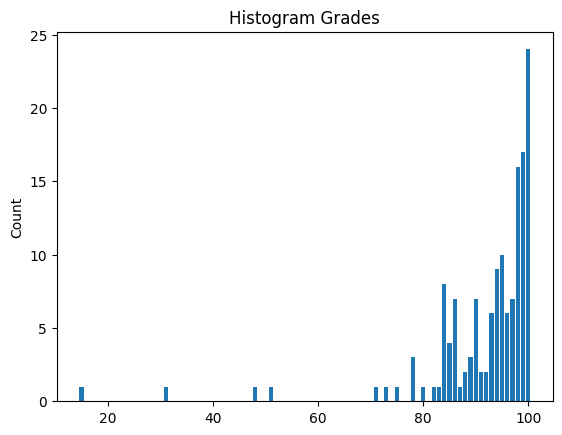

In [ ]:
# Let's check grades distribution

plt.title('Histogram Grades')
plt.hist(scores["grade"], rwidth=.8, bins=np.arange(min(scores["grade"]), max(scores["grade"])+2) - 0.5)
plt.ylabel('Count')
plt.show()

In [ ]:
df.reset_index(inplace=True, drop=False)
df.rename(columns={"index": "code"}, inplace=True)
df.head()

,code,#user_prompts,#error,#no,#thank,#next,#entropy,prompt_avg_chars,response_avg_chars
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,0.0,2.205748,212.206370
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,3.0,0.304163,113.633582
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,3.0,0.0,1.0,0.0,3.0,0.262324,17.187601
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,0.0,3.0,0.123346,107.092566
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,0.0,26.0,0.017986,18.850913


In [ ]:
df = pd.merge(df, question_mapping_scores, on="code", how="left")
df.head()

,code,#user_prompts,#error,#no,#thank,#next,#entropy,prompt_avg_chars,response_avg_chars,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,0.0,2.205748,212.206370,0.153541,0.294879,0.522169,0.352243,0.460606,0.553876,0.167250,0.182938,0.195440
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,3.0,0.304163,113.633582,0.192013,0.795607,0.772184,0.882656,0.607114,0.987511,0.892586,0.570741,0.543866
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,3.0,0.0,1.0,0.0,3.0,0.262324,17.187601,0.258306,0.295923,0.624824,0.351872,0.643038,0.454314,0.540269,0.546506,0.325793
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,0.0,3.0,0.123346,107.092566,0.145965,0.117841,0.267346,0.316809,0.333889,0.309084,0.192434,0.261892,0.407106
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,0.0,26.0,0.017986,18.850913,0.344182,0.575528,0.782883,0.624833,0.724872,0.872171,0.684797,0.945305,0.511769


#### Merging scores with features

In [ ]:
temp_df = pd.merge(df, scores, on='code', how="left")
temp_df.dropna(inplace=True)
temp_df.drop_duplicates("code",inplace=True, keep="first")
temp_df.head()

,code,#user_prompts,#error,#no,#thank,#next,#entropy,prompt_avg_chars,response_avg_chars,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8,grade
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,0.0,2.205748,212.206370,0.153541,0.294879,0.522169,0.352243,0.460606,0.553876,0.167250,0.182938,0.195440,48.0
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,3.0,0.304163,113.633582,0.192013,0.795607,0.772184,0.882656,0.607114,0.987511,0.892586,0.570741,0.543866,99.0
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,3.0,0.0,1.0,0.0,3.0,0.262324,17.187601,0.258306,0.295923,0.624824,0.351872,0.643038,0.454314,0.540269,0.546506,0.325793,90.0
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,0.0,3.0,0.123346,107.092566,0.145965,0.117841,0.267346,0.316809,0.333889,0.309084,0.192434,0.261892,0.407106,97.0
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,0.0,26.0,0.017986,18.850913,0.344182,0.575528,0.782883,0.624833,0.724872,0.872171,0.684797,0.945305,0.511769,100.0


In [ ]:
X = temp_df[temp_df.columns[1:-1]].to_numpy()
y = temp_df["grade"].to_numpy()
print(X.shape, y.shape)

(122, 17) (122,)


#### Train/Test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train set size:", len(X_train))
print("Test set size:", len(X_test))

Train set size: 97
Test set size: 25


#### Fitting a model

#### Predicting and Analyzing

In [ ]:
regressor = DecisionTreeRegressor(random_state=0,criterion='squared_error', max_depth=10)
regressor.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=10, random_state=0)

In [ ]:
extracted_MSEs = regressor.tree_.impurity
for idx, MSE in enumerate(regressor.tree_.impurity):
    print("Node {} has MSE {}".format(idx,MSE))

Node 0 has MSE 163.42034222552866
Node 1 has MSE 126.39409722222263
Node 2 has MSE 64.35004526935154
Node 3 has MSE 167.02777777777737
Node 4 has MSE 83.96484375
Node 5 has MSE 51.6875
Node 6 has MSE 0.0
Node 7 has MSE 10.489795918369055
Node 8 has MSE 0.6666666666660603
Node 9 has MSE 0.0
Node 10 has MSE 0.25
Node 11 has MSE 0.0
Node 12 has MSE 0.0
Node 13 has MSE 0.0
Node 14 has MSE 54.359375
Node 15 has MSE 1.0
Node 16 has MSE 0.0
Node 17 has MSE 0.0
Node 18 has MSE 26.58333333333303
Node 19 has MSE 12.6875
Node 20 has MSE 4.66666666666697
Node 21 has MSE 0.25
Node 22 has MSE 0.0
Node 23 has MSE 0.0
Node 24 has MSE 0.0
Node 25 has MSE 0.0
Node 26 has MSE 9.0
Node 27 has MSE 0.0
Node 28 has MSE 0.0
Node 29 has MSE 100.0
Node 30 has MSE 0.0
Node 31 has MSE 0.0
Node 32 has MSE 27.533240997230678
Node 33 has MSE 25.170927684439448
Node 34 has MSE 22.85062487601499
Node 35 has MSE 6.888888888887777
Node 36 has MSE 0.25
Node 37 has MSE 0.0
Node 38 has MSE 0.0
Node 39 has MSE 0.0
Node 40 h

In [ ]:
# Plotting the Tree
dot_data = tree.export_graphviz(regressor, out_file=None, feature_names=temp_df.columns[1:-1])
graph = graphviz.Source(dot_data)
graph.render("hw")

'hw.pdf'

In [ ]:
# Prediction
y_train_pred = regressor.predict(X_train)
y_test_pred = regressor.predict(X_test)

# Calculation of Mean Squared Error (MSE)
print("MSE Train:", mean_squared_error(y_train,y_train_pred))
print("MSE TEST:", mean_squared_error(y_test,y_test_pred))

print("R2 Train:", r2_score(y_train,y_train_pred))
print("R2 TEST:", r2_score(y_test,y_test_pred))


MSE Train: 8.279086892488953
MSE TEST: 101.55122448979591
R2 Train: 0.9493387005574656
R2 TEST: 0.09543774326422416
